In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # set to reserved number of CPUs
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from dask.diagnostics import ProgressBar
#ProgressBar().register()
from dask.distributed import LocalCluster, progress
#from dask_jobqueue import SLURMCluster
from dask.distributed import progress
import xarray as xr

# local modules
from load_SAIdata import Cases
import physics
import interpolate
import tracks
%matplotlib inline

In [2]:
#cluster = SLURMCluster(scheduler_options={'dashboard_address': 'localhost:5545'})
cluster = LocalCluster(threads_per_worker=16, dashboard_address='localhost:5545')
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/5545/status,
Dashboard: /proxy/5545/status,Workers: 1
Total threads: 16,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43425,Workers: 1
Dashboard: /proxy/5545/status,Total threads: 16
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://127.0.0.1:44445,Total threads: 16
Dashboard: /proxy/45679/status,Memory: 28.00 GiB
Nanny: tcp://127.0.0.1:38185,


In [3]:
#print(cluster.job_script())

In [4]:
%%time

tslices = {
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}

ds = {}
for exp in tslices:
    ds[exp] = xr.concat([(
        Cases(f'hres.{exp}.{ens}')
        .select('atm','h0')
        .open_mfdataset()
        .assign_coords(ens=ens)
        .sel(time=tslices[exp])
    ) for ens in range(1,7)], dim='ens')

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.004.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.005.cam2.h0.2002-12_2008-02.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2092-12.0

### 1) Calculating meridional mass stream function in Reference

In [5]:
dsi = ds['ref']
dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
             .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
dsi.MMF

<xarray.DataArray 'MMF' (lat: 768, ens: 6, time: 60, lev: 30, lon: 1152)> Size: 38GB
dask.array<astype, shape=(768, 6, 60, 30, 1152), dtype=float32, chunksize=(768, 1, 1, 30, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 480B 2003-01-01 00:00:00 ... 2007-12-01 00:00:00
  * lev      (lev) float64 240B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * ens      (ens) int64 48B 1 2 3 4 5 6
Attributes:
    long_name:  meridional mass streamfunction
    units:      kg/s

In [6]:
plev = np.array([*ds['ref'].lev[7:].data,1000]) * 100
plev  # new pressure levels (roughly similar to model levels)

array([  8782.12302923,  10331.71266317,  12154.72407639,  14299.40387607,
        16822.50797749,  19790.80867022,  23282.86189586,  27391.08167589,
        32224.19023514,  37910.09038687,  44599.25740957,  52468.71747077,
        60977.86948085,  69138.94303143,  76340.4481113 ,  82085.83686501,
        85953.4766525 ,  88702.02489197,  91264.45469446,  93619.83984709,
        95748.54795355,  97632.54073914,  99255.60951233, 100000.        ])

In [7]:
dsi['P'] = interpolate.pressure_from_hybrid(dsi)
MMF = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
    chunks=ds['ref'].MMF.chunksizes).mean('lon', keep_attrs=True)

In [8]:
MMF = MMF.persist()
progress(MMF, multi=False)

In [16]:
client.shutdown()

In [6]:
MMF = MMF.compute()

[########################################] | 100% Completed | 220.04 s


In [8]:
print(f"MMF size = {MMF.nbytes/1024**2:.3f} MiB (exp = Ref.)")

MMF size = 25.312 MiB (exp = Ref.)


Text(0.5, 1.0, 'JAS')

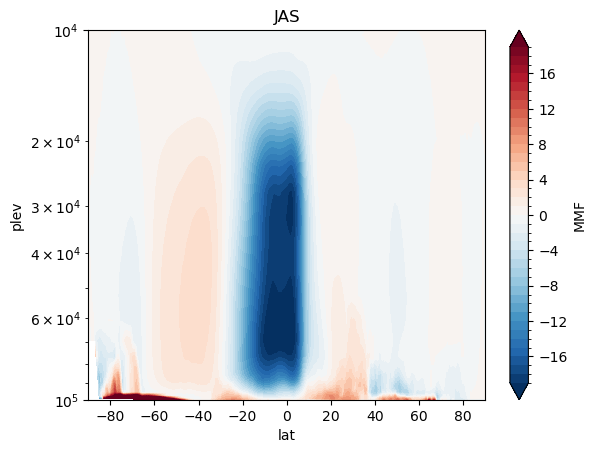

In [8]:
(MMF/1e10).groupby('time.month').mean().sel(month=[7,8,9]).mean(('ens','month')).plot.contourf(
    yincrease=False,yscale='log',y='plev',levels = np.arange(-19,19.1,1),ylim=[100000,10000])
plt.title('JAS')

Text(0.5, 1.0, 'JFM')

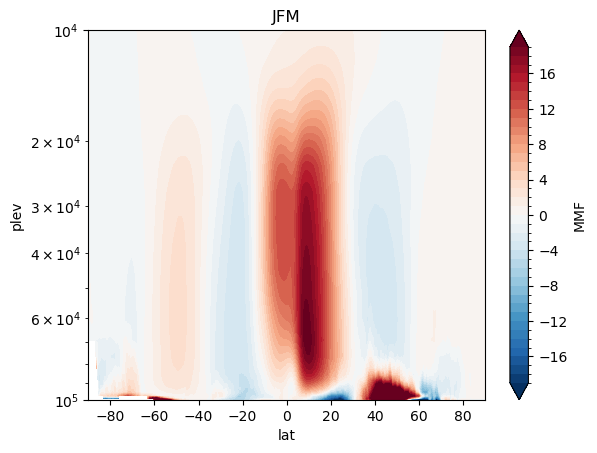

In [9]:
(MMF/1e10).groupby('time.month').mean().sel(month=[1,2,3]).mean(('ens','month')).plot.contourf(
    yincrease=False,yscale='log',y='plev',levels = np.arange(-19,19.1,1),ylim=[100000,10000])
plt.title('JFM')

Text(0.5, 1.0, 'annual')

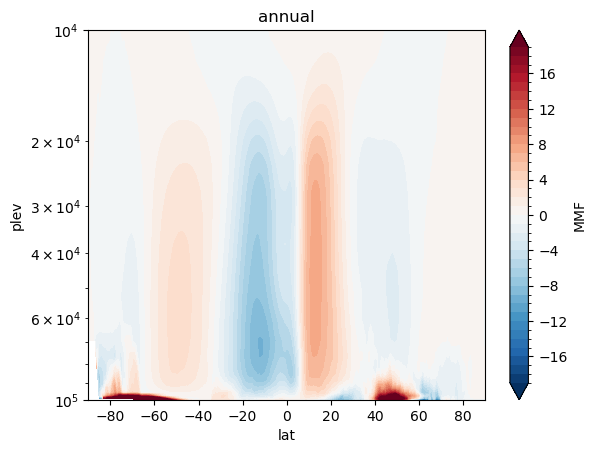

In [10]:
(MMF/1e10).mean(('ens','time'),keep_attrs=True).plot.contourf(
    yincrease=False,yscale='log',y='plev',levels = np.arange(-19,19.1,1),ylim=[100000,10000])
plt.title('annual')

### 2) Repeat for all experiments

#### computations

In [3]:
# if not isinstance(MMF, dict):
#     MMF = {'ref': MMF.assign_coords(exp='ref')}

In [4]:
# # set up calculations
# for exp in ds:
#     if exp == 'ref':
#         continue
#     dsi = ds[exp]
#     dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
#                  .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
#     dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
#     plev = np.array([*ds[exp].lev[7:].data,1000]) * 100
#     dsi['P'] = interpolate.pressure_from_hybrid(dsi)
#     MMF[exp] = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
#         chunks=ds[exp].MMF.chunksizes).mean('lon', keep_attrs=True)

In [5]:
# # execute
# for exp in MMF:
#     MMF[exp] = MMF[exp].compute()

In [6]:
# # To concatenate the experiment data from different time periods in one netCDF, 
# # we create a consistent timedelta coordinate (time - analysis start time).
# MMFds = {
#     exp: MMF[exp].assign_coords({
#         'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
#             {'description': 'days since start of analysis period'}),
#         'exp': str(exp),
#     }).swap_dims({'time':'dtime'})
#     for exp in MMF
# }
# MMFds = (
#     xr.concat(MMFds.values(), dim='exp')
#     .transpose('exp','ens','dtime','plev','lat')
#     .reset_coords('time')
# )

In [7]:
# set up calculations
MMF = {}
for exp in ds:
    dsi = ds[exp]
    dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
                 .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
    dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
    plev = np.array([*ds[exp].lev[7:].data,1000]) * 100
    dsi['P'] = interpolate.pressure_from_hybrid(dsi)
    MMF[exp] = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
        chunks=ds[exp].MMF.chunksizes).mean('lon', skipna=True, keep_attrs=True)

# To concatenate the experiment data from different time periods in one netCDF, 
# we create a consistent timedelta coordinate (time - analysis start time).
MMFds = {
    exp: MMF[exp].assign_coords({
        'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
            {'description': 'days since start of analysis period'}),
        'exp': str(exp),
    }).swap_dims({'time':'dtime'})
    for exp in MMF
}
MMFds = (
    xr.concat(MMFds.values(), dim='exp')
    .transpose('exp','ens','dtime','plev','lat')
    .reset_coords('time')
)

In [8]:
os.remove("../data/MMF.zm.nc")

In [9]:
MMFds.to_netcdf("../data/MMF.zm.nc", compute=True)

[########################################] | 100% Completed | 183.73 s


#### plotting

In [2]:
MMF = xr.open_dataset("../data/MMF.zm.nc")
MMF = {str(exp): MMF.sel(exp=exp).set_coords('time').swap_dims(
    {'dtime':'time'}).MMF for exp in MMF.exp.data}

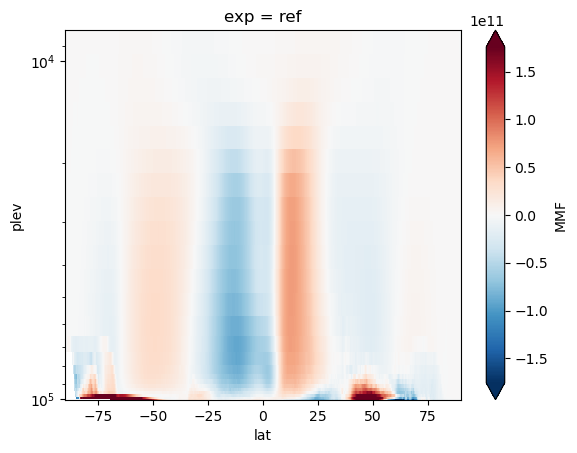

In [3]:
MMF['ref'].mean(('time','ens')).plot(y='plev',yincrease=False,yscale='log',robust=True)

saving ../figures/MMF.zm.pres.pdf...


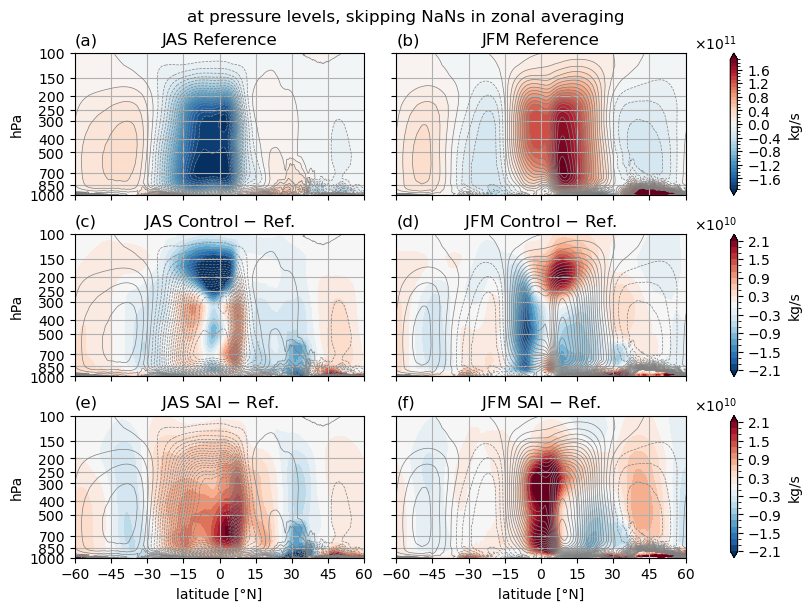

In [5]:
fig,axs = plt.subplots(3,2,layout='constrained', sharex=True, sharey=True, figsize=(8,6)) 

MMFtm = {}
for exp in MMF:
    _monmean = MMF[exp].groupby('time.month').mean(('time','ens'))
    MMFtm[exp] = xr.concat([
        _monmean.sel(month=[7,8,9]).mean('month').assign_coords(season='JAS'),
        _monmean.sel(month=[1,2,3]).mean('month').assign_coords(season='JFM'),
    ], dim='season')
    MMFtm[exp]['plev'] = MMFtm[exp].plev/100

MMFzmJAS = {exp: MMFtm[exp].sel(season='JAS') for exp in MMFtm}
MMFzmJFM = {exp: MMFtm[exp].sel(season='JFM') for exp in MMFtm}

levels_ref = np.arange(-19,19.1,1)*1e10
levels_dif = np.arange(-2.1,2.11,.2)*1e10

plots = {
    'a': {'cf': MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_ref, 'title': 'JAS Reference'},
    'b': {'cf': MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_ref, 'title': 'JFM Reference'},
    'c': {'cf': MMFzmJAS['cnt']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS Control $-$ Ref.'},
    'd': {'cf': MMFzmJFM['cnt']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM Control $-$ Ref.'},
    'e': {'cf': MMFzmJAS['sai']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS SAI $-$ Ref.'},
    'f': {'cf': MMFzmJFM['sai']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM SAI $-$ Ref.'}
}

kwargs = dict(y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)

for ax, (lab,plot) in zip(axs.flat, plots.items()):
    cf = plot['cf'].plot.contourf(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=plot['cflvls'], add_colorbar=False)
    cs = plot['cs'].plot.contour(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)
    ax.set_title(f'({lab})', loc='left')
    ax.set_title(plot['title'])
    plots[lab] = cf
    ax.set_ylim([1000,100])
    ax.set_xlim([-60,60])
    ax.set_xticks(range(-60,61,15))
    ax.set_yticks([], minor=True)
    ax.set_yticks([1000,850,700,500,400,300,250,200,150,100], 
        labels=['1000','850','700','500','400','300','250','200','150','100'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()

axs[-1,0].set_xlabel('latitude [°N]')
axs[-1,1].set_xlabel('latitude [°N]')
for ax in axs[:,0]:
    ax.set_ylabel('hPa')

cbticks_dif = np.array([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])*1e10
cb1 = fig.colorbar(plots['a'], ax=axs.flat[:2], pad=0)
cb2 = fig.colorbar(plots['c'], ax=axs.flat[2:4], ticks=cbticks_dif, pad=0)
cb3 = fig.colorbar(plots['e'], ax=axs.flat[4:6], ticks=cbticks_dif, pad=0)
for cb in (cb1, cb2, cb3):
    cb.ax.set_ylabel('kg/s')
    cb.ax.ticklabel_format(useMathText=True)

fig.suptitle("at pressure levels, skipping NaNs in zonal averaging")
#os.remove("../figures/MMF.zm.pres.pdf")
tracks.savefig(fig, "MMF.zm.pres.pdf", dpi=300, transparent=True)

### 3) Repeat, but take zonal mean without skipping NaN's

#### calculations

In [50]:
# set up calculations
MMF = {}
for exp in ds:
    dsi = ds[exp]
    dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
                 .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
    dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
    plev = np.array([*ds[exp].lev[7:].data,1000]) * 100
    dsi['P'] = interpolate.pressure_from_hybrid(dsi)
    MMF[exp] = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
        chunks=ds[exp].MMF.chunksizes).mean('lon', skipna=False, keep_attrs=True)

In [51]:
# execute
for exp in MMF:
    MMF[exp] = MMF[exp].compute()

[########################################] | 100% Completed | 220.51 s
[########################################] | 100% Completed | 218.43 s
[########################################] | 100% Completed | 219.71 s


In [52]:
# To concatenate the experiment data from different time periods in one netCDF, 
# we create a consistent timedelta coordinate (time - analysis start time).
MMFds = {
    exp: MMF[exp].assign_coords({
        'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
            {'description': 'days since start of analysis period'}),
        'exp': str(exp),
    }).swap_dims({'time':'dtime'})
    for exp in MMF
}
MMFds = (
    xr.concat(MMFds.values(), dim='exp')
    .transpose('exp','ens','dtime','plev','lat')
    .reset_coords('time')
)

In [53]:
xr.Dataset(MMFds).to_netcdf("../data/MMF.zm.nan.nc")

#### plotting

In [6]:
MMF = xr.open_dataset("../data/MMF.zm.nan.nc")
MMF = {str(exp): MMF.sel(exp=exp).set_coords('time').swap_dims(
    {'dtime':'time'}).MMF for exp in MMF.exp.data}

saving ../figures/MMF.zm.pres.NaN.pdf...


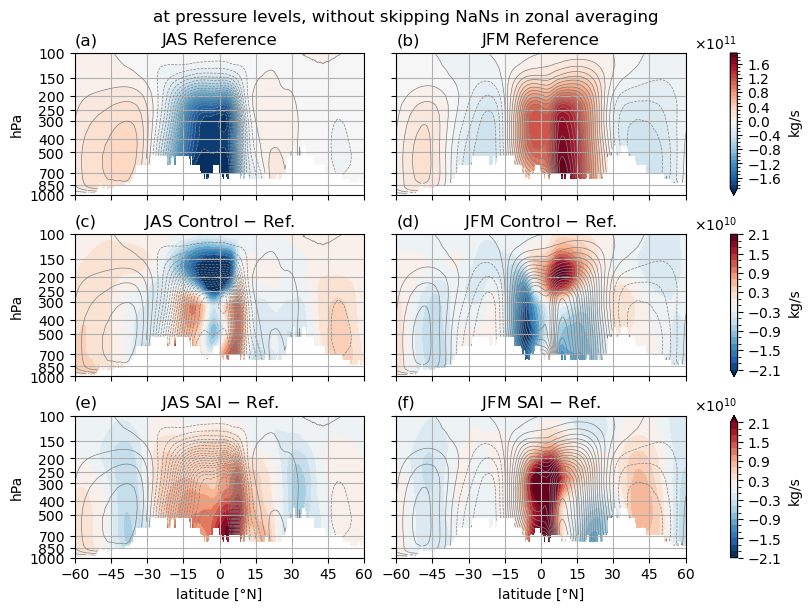

In [7]:
fig,axs = plt.subplots(3,2,layout='constrained', sharex=True, sharey=True, figsize=(8,6)) 

MMFtm = {}
for exp in MMF:
    _monmean = MMF[exp].groupby('time.month').mean(('time','ens'))
    MMFtm[exp] = xr.concat([
        _monmean.sel(month=[7,8,9]).mean('month').assign_coords(season='JAS'),
        _monmean.sel(month=[1,2,3]).mean('month').assign_coords(season='JFM'),
    ], dim='season')
    MMFtm[exp]['plev'] = MMFtm[exp].plev/100

MMFzmJAS = {exp: MMFtm[exp].sel(season='JAS') for exp in MMFtm}
MMFzmJFM = {exp: MMFtm[exp].sel(season='JFM') for exp in MMFtm}

levels_ref = np.arange(-19,19.1,1)*1e10
levels_dif = np.arange(-2.1,2.11,.2)*1e10

plots = {
    'a': {'cf': MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_ref, 'title': 'JAS Reference'},
    'b': {'cf': MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_ref, 'title': 'JFM Reference'},
    'c': {'cf': MMFzmJAS['cnt']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS Control $-$ Ref.'},
    'd': {'cf': MMFzmJFM['cnt']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM Control $-$ Ref.'},
    'e': {'cf': MMFzmJAS['sai']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS SAI $-$ Ref.'},
    'f': {'cf': MMFzmJFM['sai']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM SAI $-$ Ref.'}
}

kwargs = dict(y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)

for ax, (lab,plot) in zip(axs.flat, plots.items()):
    cf = plot['cf'].plot.contourf(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=plot['cflvls'], add_colorbar=False)
    cs = plot['cs'].plot.contour(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)
    ax.set_title(f'({lab})', loc='left')
    ax.set_title(plot['title'])
    plots[lab] = cf
    ax.set_ylim([1000,100])
    ax.set_xlim([-60,60])
    ax.set_xticks(range(-60,61,15))
    ax.set_yticks([], minor=True)
    ax.set_yticks([1000,850,700,500,400,300,250,200,150,100], 
        labels=['1000','850','700','500','400','300','250','200','150','100'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()

axs[-1,0].set_xlabel('latitude [°N]')
axs[-1,1].set_xlabel('latitude [°N]')
for ax in axs[:,0]:
    ax.set_ylabel('hPa')

cbticks_dif = np.array([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])*1e10
cb1 = fig.colorbar(plots['a'], ax=axs.flat[:2], pad=0)
cb2 = fig.colorbar(plots['c'], ax=axs.flat[2:4], ticks=cbticks_dif, pad=0)
cb3 = fig.colorbar(plots['e'], ax=axs.flat[4:6], ticks=cbticks_dif, pad=0)
for cb in (cb1, cb2, cb3):
    cb.ax.set_ylabel('kg/s')
    cb.ax.ticklabel_format(useMathText=True)

fig.suptitle("at pressure levels, without skipping NaNs in zonal averaging")
tracks.savefig(fig, "MMF.zm.pres.NaN.pdf", dpi=300, transparent=True)

### 4) Repeat, but now at model levels instead of pressure levels

#### computations

In [79]:
# set up calculations
MMF = {}
for exp in ds:
    dsi = ds[exp]
    dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
                 .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
    dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
    MMF[exp] = dsi.MMF.mean('lon', keep_attrs=True)

In [80]:
MMF = {exp: MMF[exp].compute() for exp in MMF}

[########################################] | 100% Completed | 95.74 s
[########################################] | 100% Completed | 98.84 s
[########################################] | 100% Completed | 95.84 s


In [81]:
# To concatenate the experiment data from different time periods in one netCDF, 
# we create a consistent timedelta coordinate (time - analysis start time).
MMFds = {
    exp: MMF[exp].assign_coords({
        'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
            {'description': 'days since start of analysis period'}),
        'exp': str(exp),
    }).swap_dims({'time':'dtime'})
    for exp in MMF
}
MMFds = (
    xr.concat(MMFds.values(), dim='exp')
    .transpose('exp','ens','dtime','lev','lat')
    .reset_coords('time')
)

In [82]:
xr.Dataset(MMFds).to_netcdf("../data/MMF.zm.hybrid.nc")

#### plotting

In [8]:
MMF = xr.open_dataset("../data/MMF.zm.hybrid.nc")
MMF = {str(exp): MMF.sel(exp=exp).set_coords('time').swap_dims(
    {'dtime':'time'}).MMF for exp in MMF.exp.data}

saving ../figures/MMF.zm.hybrid.pdf...


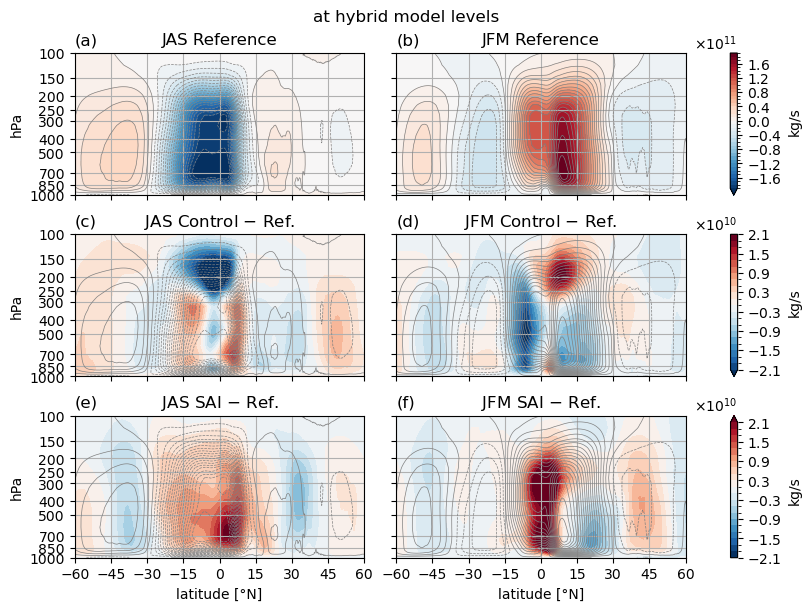

In [9]:
fig,axs = plt.subplots(3,2,layout='constrained', sharex=True, sharey=True, figsize=(8,6)) 

MMFtm = {}
for exp in MMF:
    _monmean = MMF[exp].groupby('time.month').mean(('time','ens'))
    MMFtm[exp] = xr.concat([
        _monmean.sel(month=[7,8,9]).mean('month').assign_coords(season='JAS'),
        _monmean.sel(month=[1,2,3]).mean('month').assign_coords(season='JFM'),
    ], dim='season')
    # MMFtm[exp]['plev'] = MMFtm[exp].plev/100

MMFzmJAS = {exp: MMFtm[exp].sel(season='JAS') for exp in MMFtm}
MMFzmJFM = {exp: MMFtm[exp].sel(season='JFM') for exp in MMFtm}

levels_ref = np.arange(-19,19.1,1)*1e10
levels_dif = np.arange(-2.1,2.11,.2)*1e10

plots = {
    'a': {'cf': MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_ref, 'title': 'JAS Reference'},
    'b': {'cf': MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_ref, 'title': 'JFM Reference'},
    'c': {'cf': MMFzmJAS['cnt']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS Control $-$ Ref.'},
    'd': {'cf': MMFzmJFM['cnt']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM Control $-$ Ref.'},
    'e': {'cf': MMFzmJAS['sai']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS SAI $-$ Ref.'},
    'f': {'cf': MMFzmJFM['sai']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM SAI $-$ Ref.'}
}

kwargs = dict(y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)

for ax, (lab,plot) in zip(axs.flat, plots.items()):
    cf = plot['cf'].plot.contourf(ax=ax, y='lev', yincrease=False, yscale='log', 
        levels=plot['cflvls'], add_colorbar=False)
    cs = plot['cs'].plot.contour(ax=ax, y='lev', yincrease=False, yscale='log', 
        levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)
    ax.set_title(f'({lab})', loc='left')
    ax.set_title(plot['title'])
    plots[lab] = cf
    ax.set_ylim([1000,100])
    ax.set_xlim([-60,60])
    ax.set_xticks(range(-60,61,15))
    ax.set_yticks([], minor=True)
    ax.set_yticks([1000,850,700,500,400,300,250,200,150,100], 
        labels=['1000','850','700','500','400','300','250','200','150','100'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()

axs[-1,0].set_xlabel('latitude [°N]')
axs[-1,1].set_xlabel('latitude [°N]')
for ax in axs[:,0]:
    ax.set_ylabel('hPa')

cbticks_dif = np.array([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])*1e10
cb1 = fig.colorbar(plots['a'], ax=axs.flat[:2], pad=0)
cb2 = fig.colorbar(plots['c'], ax=axs.flat[2:4], ticks=cbticks_dif, pad=0)
cb3 = fig.colorbar(plots['e'], ax=axs.flat[4:6], ticks=cbticks_dif, pad=0)
for cb in (cb1, cb2, cb3):
    cb.ax.set_ylabel('kg/s')
    cb.ax.ticklabel_format(useMathText=True)

fig.suptitle("at hybrid model levels")
tracks.savefig(fig, "MMF.zm.hybrid.pdf", dpi=300, transparent=True)

### 5) Repeat, at pressure levels but filling NaNs with 0s

#### computations

In [4]:
# # set up calculations
# MMF = {}
# for exp in ds:
#     dsi = ds[exp]
#     dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
#                  .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
#     dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
#     plev = np.array([*ds[exp].lev[7:].data,1000]) * 100
#     dsi['P'] = interpolate.pressure_from_hybrid(dsi)
#     MMF[exp] = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
#         chunks=ds[exp].MMF.chunksizes).fillna(0).mean('lon', keep_attrs=True)

# # To concatenate the experiment data from different time periods in one netCDF, 
# # we create a consistent timedelta coordinate (time - analysis start time).
# MMFds = {
#     exp: MMF[exp].assign_coords({
#         'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
#             {'description': 'days since start of analysis period'}),
#         'exp': str(exp),
#     }).swap_dims({'time':'dtime'})
#     for exp in MMF
# }
# MMFds = (
#     xr.concat(MMFds.values(), dim='exp')
#     .transpose('exp','ens','dtime','plev','lat')
#     .reset_coords('time')
# )

In [10]:
# set up calculations
MMF = {}
for exp in ds:
    dsi = ds[exp]
    dsi['dP'] = (interpolate.pressure_from_hybrid(dsi, cell_interface=True)
                 .diff('ilev').rename({'ilev':'lev'}).assign_coords(lev=dsi.lev))
    dsi['MMF'] = physics.meridional_mass_streamfunction(dsi.V, dsi.dP, dsi.lat)
    plev = np.array([*ds[exp].lev[7:].data,1000]) * 100
    dsi['P'] = interpolate.pressure_from_hybrid(dsi)
    MMF[exp] = interpolate.interpolate(dsi.MMF, dsi.P, plev, 'lev', 
        chunks=ds[exp].MMF.chunksizes).fillna(0).mean('lon', skipna=False, keep_attrs=True)

# To concatenate the experiment data from different time periods in one netCDF, 
# we create a consistent timedelta coordinate (time - analysis start time).
MMFds = {
    exp: MMF[exp].assign_coords({
        'dtime': (MMF[exp].time-MMF[exp].time[0]).dt.days.assign_attrs(
            {'description': 'days since start of analysis period'}),
        'exp': str(exp),
    }).swap_dims({'time':'dtime'})
    for exp in MMF
}
MMFds = (
    xr.concat(MMFds.values(), dim='exp')
    .transpose('exp','ens','dtime','plev','lat')
    .reset_coords('time')
)

In [11]:
os.remove("../data/MMF.zm.0.nc")

In [12]:
MMFds.to_netcdf('../data/MMF.zm.0.nc', compute=True)

[########################################] | 100% Completed | 183.35 s


#### plotting

In [6]:
MMF = xr.open_dataset("../data/MMF.zm.0.nc")
MMF = {str(exp): MMF.sel(exp=exp).set_coords('time').swap_dims(
    {'dtime':'time'}).MMF for exp in MMF.exp.data}

saving ../figures/MMF.zm.pres.0.pdf...


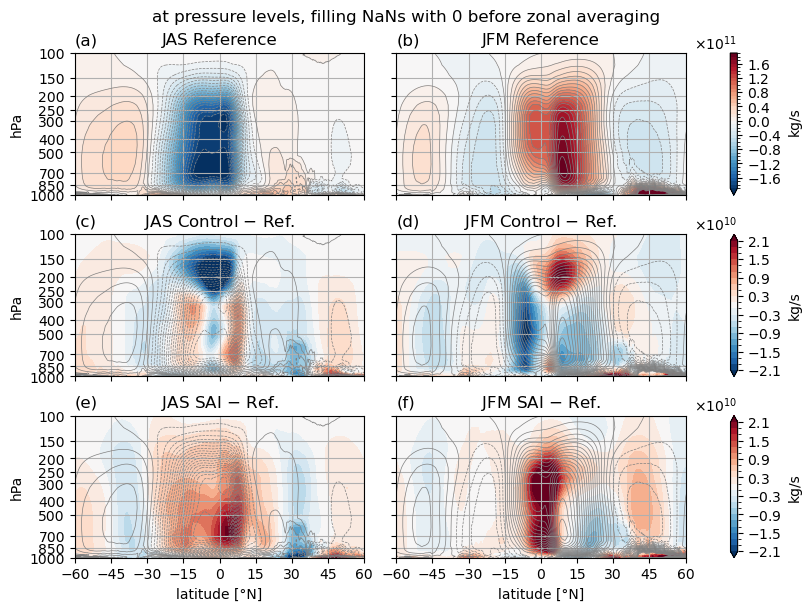

In [7]:
fig,axs = plt.subplots(3,2,layout='constrained', sharex=True, sharey=True, figsize=(8,6)) 

MMFtm = {}
for exp in MMF:
    _monmean = MMF[exp].groupby('time.month').mean(('time','ens'))
    MMFtm[exp] = xr.concat([
        _monmean.sel(month=[7,8,9]).mean('month').assign_coords(season='JAS'),
        _monmean.sel(month=[1,2,3]).mean('month').assign_coords(season='JFM'),
    ], dim='season')
    MMFtm[exp]['plev'] = MMFtm[exp].plev/100

MMFzmJAS = {exp: MMFtm[exp].sel(season='JAS') for exp in MMFtm}
MMFzmJFM = {exp: MMFtm[exp].sel(season='JFM') for exp in MMFtm}

levels_ref = np.arange(-19,19.1,1)*1e10
levels_dif = np.arange(-2.1,2.11,.2)*1e10

plots = {
    'a': {'cf': MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_ref, 'title': 'JAS Reference'},
    'b': {'cf': MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_ref, 'title': 'JFM Reference'},
    'c': {'cf': MMFzmJAS['cnt']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS Control $-$ Ref.'},
    'd': {'cf': MMFzmJFM['cnt']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM Control $-$ Ref.'},
    'e': {'cf': MMFzmJAS['sai']-MMFzmJAS['ref'], 'cs': MMFzmJAS['ref'],
          'cflvls': levels_dif, 'title': 'JAS SAI $-$ Ref.'},
    'f': {'cf': MMFzmJFM['sai']-MMFzmJFM['ref'], 'cs': MMFzmJFM['ref'],
          'cflvls': levels_dif, 'title': 'JFM SAI $-$ Ref.'}
}

kwargs = dict(y='lev', yincrease=False, yscale='log', levels=levels_ref, add_colorbar=False)

for ax, (lab,plot) in zip(axs.flat, plots.items()):
    cf = plot['cf'].plot.contourf(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=plot['cflvls'], add_colorbar=False)
    cs = plot['cs'].plot.contour(ax=ax, y='plev', yincrease=False, yscale='log', 
        levels=levels_ref, colors='grey', linewidths=0.5, add_colorbar=False)
    ax.set_title(f'({lab})', loc='left')
    ax.set_title(plot['title'])
    plots[lab] = cf
    ax.set_ylim([1000,100])
    ax.set_xlim([-60,60])
    ax.set_xticks(range(-60,61,15))
    ax.set_yticks([], minor=True)
    ax.set_yticks([1000,850,700,500,400,300,250,200,150,100], 
        labels=['1000','850','700','500','400','300','250','200','150','100'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid()

axs[-1,0].set_xlabel('latitude [°N]')
axs[-1,1].set_xlabel('latitude [°N]')
for ax in axs[:,0]:
    ax.set_ylabel('hPa')

cbticks_dif = np.array([-2.1,-1.5,-0.9,-0.3,0.3,0.9,1.5,2.1])*1e10
cb1 = fig.colorbar(plots['a'], ax=axs.flat[:2], pad=0)
cb2 = fig.colorbar(plots['c'], ax=axs.flat[2:4], ticks=cbticks_dif, pad=0)
cb3 = fig.colorbar(plots['e'], ax=axs.flat[4:6], ticks=cbticks_dif, pad=0)
for cb in (cb1, cb2, cb3):
    cb.ax.set_ylabel('kg/s')
    cb.ax.ticklabel_format(useMathText=True)

fig.suptitle("at pressure levels, filling NaNs with 0 before zonal averaging")
#os.remove("../figures/MMF.zm.pres.0.pdf")
tracks.savefig(fig, "MMF.zm.pres.0.pdf", dpi=300, transparent=True)

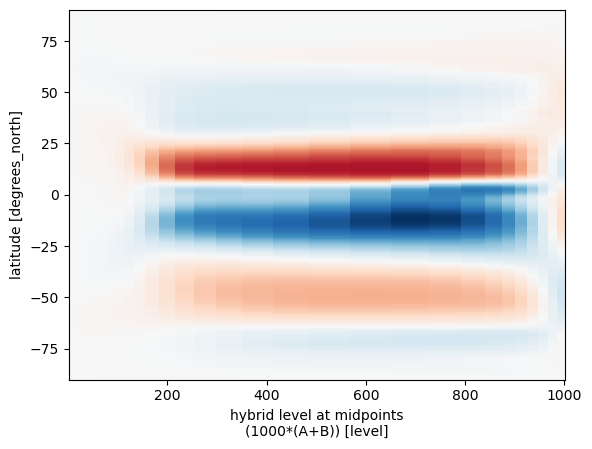

In [12]:
MMFzm['ref'].mean('ens').plot(ax=ax, y='lev', yincrease=False, yscale='log', 
        levels=np.arange(-19,19.1,1)*1e10, add_colorbar=False)

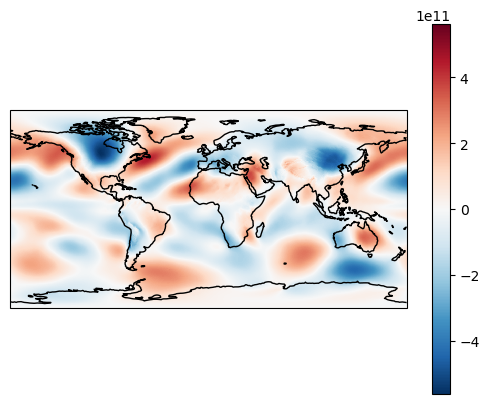

In [26]:
ax = plt.axes(projection=ccrs.PlateCarree())
MMFvm.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
%%time

tslices = {
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}

ds = {}
for exp in tslices:
    ds[exp] = xr.concat([(
        Cases(f'hres.{exp}.{ens}')
        .select('atm','h0')
        .open_mfdataset()
        .assign_coords(ens=ens)
        .sel(time=tslices[exp])
    ) for ens in range(1,7)], dim='ens')

In [6]:
ds.close()
ds = Cases('hres.ref.6').select('atm','h5').open_mfdataset()

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h5.2002-12-01-10800_2007-12-01-10800.json
